### Code for quantifying performance of the trained model
This notebook is adapted from Koger et al. (2023)

In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch 
from torchvision.ops import nms

import detectron2
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import detection_utils as utils
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model

import sys
sys.path.append('./functions')

from detectron2_classes.DetectionDatasetMapper import DetectionDatasetMapper
from detectron2_classes.GroundtruthVisualizer import GroundtruthVisualizer
from detectron2_classes.PrecisionRecallEvaluator import PrecisionRecallEvaluator


In [2]:
detectron2.__version__

'0.2'

In [3]:
# Name of model to evaluate
model_name = "megaherd-random-plateau-LRscheduler-cropped-color-aug-new-dataloader_6-6-23_maxiter-9000_lr-0.0019_detectPerIm-800_minsize-0_batchsize-8_nms-0"

In [4]:
base_folder = '/home/blair/mababe-megaherd-data/data/annotations'
images_folder = os.path.join(base_folder, "annotated_images")

In [5]:
models_folder = os.path.join("./output")
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')

In [6]:
cfg = get_cfg()
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)

cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False

weights_path = sorted(
    glob.glob(os.path.join(models_folder, model_name, "best-model-config-iter-*.pth"))
)[-1]
print(weights_path)
cfg.MODEL.WEIGHTS = os.path.join(weights_path)

/home/blair/mababe-megaherd-data/output/megaherd-random-plateau-LRscheduler-cropped-color-aug-new-dataloader_6-6-23_maxiter-9000_lr-0.0019_detectPerIm-800_minsize-0_batchsize-8_nms-0/best-model-config-iter-2249-loss-0.20551486595458612.pth


In [7]:
print(cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
print(cfg.MODEL.ROI_HEADS.NUM_CLASSES)

0.05
1


In [8]:
# Annotated datasets to use for performance quantification
train_json = os.path.join(base_folder, 'random_train_megaherd.json') 
val_json = os.path.join(base_folder, 'random_val_megaherd.json')

register_coco_instances("train", {}, train_json, images_folder)
register_coco_instances("val", {}, val_json, images_folder)
# register_coco_instances("test", {}, test_json, images_folder)

train_dicts = DatasetCatalog.get("train")
val_dicts = DatasetCatalog.get("val")
# test_dicts = DatasetCatalog.get("test")

num_train_images = len(train_dicts)
num_val_images = len(val_dicts)
# num_test_images = len(test_dicts)
print(f"{num_train_images} training images \n",
      f"{num_val_images} validation images \n")#,
     # f"{num_test_images} test images"
   #  )

366 training images 
 92 validation images 



In [9]:
train_metadata = MetadataCatalog.get("train")
train_metadata.get("thing_classes")

['buffalo']

In [10]:
# Name of one of the datasets specified above to actually use
dataset_name = "val"
mapper = DetectionDatasetMapper(cfg, is_train=False, calc_val_loss=False)
loader = build_detection_test_loader(cfg, dataset_name, mapper)

### Visualize predictions on two images

In [11]:
# Check model performance on the specified set
evaluator = PrecisionRecallEvaluator(dataset_name, cfg, distributed=False, min_iou=.2)
evaluator.reset()

cfg.DATASETS.TEST = (dataset_name, )

model = build_model(cfg)
_ = model.eval()

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

with torch.no_grad():
    for batch_num, batch in enumerate(loader):
        
        if batch_num % 50 == 0:
            print(f'processed batch {batch_num}')
        outputs = model(batch)
        
        instances = outputs[0]["instances"]
        # Postprocessing
        valid_ind = nms(instances.pred_boxes.tensor, instances.scores, iou_threshold=.5)
        instances.pred_boxes.tensor = instances.pred_boxes.tensor[valid_ind]
        instances.scores = instances.scores[valid_ind]
        instances.pred_classes = instances.pred_classes[valid_ind]
        outputs[0]["instances"] = instances
        
        evaluator.process(batch, outputs)             

coco_result = evaluator.evaluate()

custom
Using custom min iou: 0.2


Some model parameters or buffers are not found in the checkpoint:
proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


processed batch 0


/home/blair/detectron2env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


processed batch 50
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Using min iou threshold of 0.2.
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.01 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.20:0.95 | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.868
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.378
 Average Precision  (AP) @[ IoU=0.20:0.95 | area= small | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.20:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.20:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.20:0.95 | area=   all | maxDets=  1 ] = 0.063
 Average Recall     (AR) @[ IoU=0.20:0.95 | area=   all | maxDets= 10 ] = 0.445
 Average Recall     (AR) 

Max detections: 100


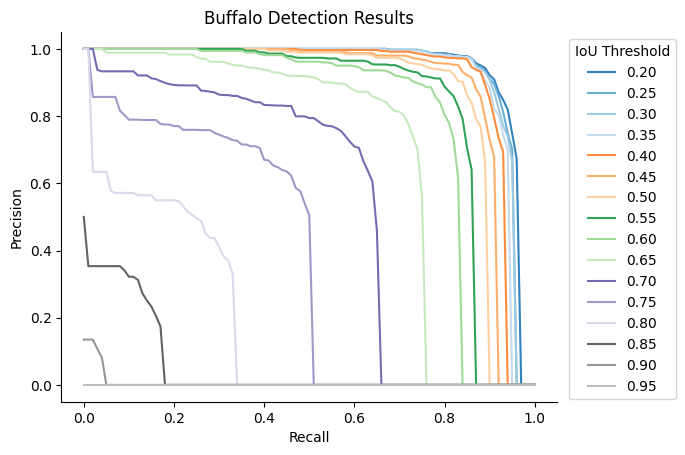

In [12]:
params = coco_result['bbox']['params']
precision = coco_result['bbox']['precision']

max_dets_ind = 2
print(f"Max detections: {params.maxDets[max_dets_ind]}")

area_rng_ind = 0 # 0 corresponds to all detection sizes

cm = plt.cm.tab20c

for obj_class, _ in enumerate(precision[0, 0, :, 0, 0]):
    plt.figure()
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for iou_ind, iou_thrsh in enumerate(params.iouThrs):
        plt.plot(params.recThrs, 
                 precision[iou_ind, :, obj_class, area_rng_ind, max_dets_ind], 
                 label=f"{iou_thrsh:.2f}", c=cm(iou_ind/len(params.iouThrs)))
    #plt.plot(recalls, precisions, 'ro')
    plt.legend(title='IoU Threshold', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.title("Buffalo Detection Results")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
plt.savefig('/home/blair/server/herd_hover/megaherd/figure4.png', bbox_inches='tight')

In [13]:
# default iou thresh values are 
# [0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]
iou_thresh_ind = 6
print(f"Using an iou threshold of {params.iouThrs[iou_thresh_ind]}")

score_thresh = .2
print(f"Using score threshold of {score_thresh}")

max_dets_ind = 2 

area_rng_ind = 0 # 0 corresponds to all detection sizes
print(f"Using area size range {params.areaRng[area_rng_ind]}")

print("")

scores = coco_result['bbox']['scores']

for obj_class, obj_name in enumerate(train_metadata.get("thing_classes")):  
    above_thresh = np.argwhere(
        scores[iou_thresh_ind, :, obj_class, area_rng_ind, max_dets_ind] >= score_thresh)
    if len(above_thresh) == 0:
        print(f"{obj_name:8}: recall: {np.nan:1.2f}, precision: {np.nan:1.3f}")
        continue
    max_ind = np.max(above_thresh)
    print(f"{obj_name:8}: recall: {params.recThrs[max_ind]:1.2f}, "
          f"precision: {precision[iou_thresh_ind, max_ind, obj_class, area_rng_ind, max_dets_ind]:1.3f}")

Using an iou threshold of 0.5
Using score threshold of 0.2
Using area size range [0, 10000000000.0]

buffalo : recall: 0.88, precision: 0.768
